In [683]:
import pandas as pd

url = "postgresql://localhost/test?user=postgres&password=248655"


def batch_load_sql(query: str) -> pd.DataFrame:
    CHUNKSIZE = 200000

    chunks = []
    for chunk_dataframe in pd.read_sql(query, url, chunksize=CHUNKSIZE):
        chunks.append(chunk_dataframe)
    return pd.concat(chunks, ignore_index=True)


data = batch_load_sql("""
SELECT pe.name, pe.description, pe.time_start, pe.ticket_type_id,
    ptt.price,
    pe.theme_id, pt.name AS theme_name,
    pet.name AS type_name
FROM program_event pe 
JOIN core_tickettype ptt ON pe.ticket_type_id=ptt.id
JOIN program_eventtype pet ON pe.type_id=pet.id
JOIN program_theme pt ON pe.theme_id=pt.id
WHERE pe.published=TRUE""")
data

,name,description,time_start,ticket_type_id,price,theme_id,theme_name,type_name
0,Мастер-Класс от партнера Hochland. Трендовые рецепты пиццы.,,2021-10-07 11:30:00+00:00,169,0.0,1,ПИР-РЕСТОРАН 2021,Мастер-класс
1,"Виды пасты и равиоли, техника лепки.",Уточняется,2021-10-05 11:30:00+00:00,155,0.0,1,ПИР-РЕСТОРАН 2021,Мастер-класс
2,Современное проектирование кухонных пространств в отеле.,*Уточняется*,2022-10-18 12:45:00+00:00,473,1500.0,10,ПИР-РЕСТОРАН 2022,Семинар
3,Подбор оборудования для кондитерского и пекарского цеха в зависимости от размера помещения и потребностей.,,2021-10-05 07:30:00+00:00,122,2000.0,1,ПИР-РЕСТОРАН 2021,Семинар
4,Волжские сезоны: особенности работы с локальными продуктами,,2021-10-07 12:30:00+00:00,13,0.0,1,ПИР-РЕСТОРАН 2021,Мастер-класс
...,...,...,...,...,...,...,...,...
1030,В центре внимания гость: как получить свою аудиторию и повысить доходы или что такое hotel staging,Основные темы сессии:<br>1. Аналитика и методы изучения потребностей гостей.<br>2. Непрерывный цикл работы с качеством.<br>3. Создание фокусного продукта и трансформация услуги.<br>4. Комплексный подход к раскрытию потенциала отеля.,2024-10-21 07:30:00+00:00,1167,2700.0,42,ПИР-ОТЕЛЬ 2024,Семинар
1031,Сезонность.НЕТ. Партнерство ОТА и отеля круглый год,- Как ОТА могут помочь поднять загрузку в низкий сезон? Рекомендации для отелей по сезонным предложениям<br>\t- Новые гости – новые возможности. Рост продаж вместе с ОТА<br>\t- Партнерские отношения между ОТА и отелем – возможно ли?,2024-10-22 10:40:00+00:00,1170,0.0,42,ПИР-ОТЕЛЬ 2024,Экспертная сессия
1032,Проведение Стратегической сессии для команды отеля как основа бюджетирования и ответственности за достижение результата,На сессии поговорим об эффективном формате работы с командой отеля - стратегической сессии. Он актуален для коллективов разных размеров: от небольшого независимого отеля до большой управляющей компании.<br>Основные вопросы сессии:<br>\t- Стратегическая сессия как способ открытого планирования<br>\t- Методика проведения стратегической сессии силами отеля<br>\t- Участие команды отеля в разработке бизнес-процессов и формировании плана работ для достижения целей <br>\t- Вовлечение в реализацию разрабортанного плана и методы контроля,2024-10-22 09:30:00+00:00,996,2700.0,42,ПИР-ОТЕЛЬ 2024,Семинар
1033,200 сэндвичей с мортаделлой и 120 чашек кофе в день: как создавалась и работает нашумевшая Masa Madre,Как появилась идея создать проект и почему он такой красивый?<br>Как собрать команду мечты?<br>Лидеры продаж и 30 тысяч подписок за первые 3 месяца. <br>Про хлеб и манки бред от первого лица. <br>План развития и шаги реализации.,2024-10-23 13:20:00+00:00,1171,1000.0,38,ПИР-КОФЕ 2024,Лекция


In [684]:
import re


def clean_text(x):
    if pd.notna(x):
        s = str(x).strip().lower()

        s = re.sub(r'(?<=\s)[^\w\s]+(?=\s)', '', s)
        s = re.sub(r'(?<=\w|\d)[\W\d]+(?=\w|\d)', ' ', s)
        s = re.sub(r'(?<=\w|\d)[\W\d]+$', ' ', s)
        s = re.sub(r'^[^a-zA-Zа-яА-Я]+', '', s)

        return ' '.join(s.strip().split())
    return ''


data['name'] = data['name'].apply(clean_text)
data['description'] = data['description'].apply(clean_text)
data['type_name'] = data['type_name'].apply(clean_text)
data

,name,description,time_start,ticket_type_id,price,theme_id,theme_name,type_name
0,мастер класс от партнера hochland трендовые рецепты пиццы,,2021-10-07 11:30:00+00:00,169,0.0,1,ПИР-РЕСТОРАН 2021,мастер класс
1,виды пасты и равиоли техника лепки,уточняется,2021-10-05 11:30:00+00:00,155,0.0,1,ПИР-РЕСТОРАН 2021,мастер класс
2,современное проектирование кухонных пространств в отеле,уточняется,2022-10-18 12:45:00+00:00,473,1500.0,10,ПИР-РЕСТОРАН 2022,семинар
3,подбор оборудования для кондитерского и пекарского цеха в зависимости от размера помещения и потребностей,,2021-10-05 07:30:00+00:00,122,2000.0,1,ПИР-РЕСТОРАН 2021,семинар
4,волжские сезоны особенности работы с локальными продуктами,,2021-10-07 12:30:00+00:00,13,0.0,1,ПИР-РЕСТОРАН 2021,мастер класс
...,...,...,...,...,...,...,...,...
1030,в центре внимания гость как получить свою аудиторию и повысить доходы или что такое hotel staging,основные темы сессии br аналитика и методы изучения потребностей гостей br непрерывный цикл работы с качеством br создание фокусного продукта и трансформация услуги br комплексный подход к раскрытию потенциала отеля,2024-10-21 07:30:00+00:00,1167,2700.0,42,ПИР-ОТЕЛЬ 2024,семинар
1031,сезонность нет партнерство ота и отеля круглый год,как ота могут помочь поднять загрузку в низкий сезон рекомендации для отелей по сезонным предложениям br новые гости новые возможности рост продаж вместе с ота br партнерские отношения между ота и отелем возможно ли,2024-10-22 10:40:00+00:00,1170,0.0,42,ПИР-ОТЕЛЬ 2024,экспертная сессия
1032,проведение стратегической сессии для команды отеля как основа бюджетирования и ответственности за достижение результата,на сессии поговорим об эффективном формате работы с командой отеля стратегической сессии он актуален для коллективов разных размеров от небольшого независимого отеля до большой управляющей компании br основные вопросы сессии br стратегическая сессия как способ открытого планирования br методика проведения стратегической сессии силами отеля br участие команды отеля в разработке бизнес процессов и формировании плана работ для достижения целей br вовлечение в реализацию разрабортанного плана и методы контроля,2024-10-22 09:30:00+00:00,996,2700.0,42,ПИР-ОТЕЛЬ 2024,семинар
1033,сэндвичей с мортаделлой и чашек кофе в день как создавалась и работает нашумевшая masa madre,как появилась идея создать проект и почему он такой красивый br как собрать команду мечты br лидеры продаж и тысяч подписок за первые месяца br про хлеб и манки бред от первого лица br план развития и шаги реализации,2024-10-23 13:20:00+00:00,1171,1000.0,38,ПИР-КОФЕ 2024,лекция


In [685]:
data.isna().sum()

name              0
description       0
time_start        0
ticket_type_id    0
price             0
theme_id          0
theme_name        0
type_name         0
dtype: int64

In [686]:
data[['theme_id', 'theme_name']].value_counts()

theme_id  theme_name          
23        ПИР-РЕСТОРАН 2023       172
34        ПИР-РЕСТОРАН 2024       158
10        ПИР-РЕСТОРАН 2022       142
1         ПИР-РЕСТОРАН 2021       137
2         ПИР-ОТЕЛЬ 2021           73
42        ПИР-ОТЕЛЬ 2024           70
24        ПИР-ОТЕЛЬ 2023           68
9         ПИР-ОТЕЛЬ 2022           45
11        ПИР-КОФЕ 2022            44
22        ПИР-КОФЕ 2023            44
38        ПИР-КОФЕ 2024            41
25        ПИР-ФРАНЧАЙЗИНГ 2023     22
17        ПИР-ФРАНЧАЙЗИНГ 2022     19
Name: count, dtype: int64

In [687]:
restaurant = [1, 10, 23, 34]
franchising = [17, 25]
coffee = [11, 22, 38]
hotel = [2, 9, 24, 42]

In [688]:
def filter_theme(x):
    if x in coffee:
        return 'кофе'
    elif x in hotel:
        return 'отель'
    elif x in restaurant:
        return 'ресторан'
    elif x in franchising:
        return 'франчайзинг'

    return 'nan'


data['theme'] = data['theme_id'].apply(filter_theme)
data.drop(columns=['theme_id', 'theme_name'], inplace=True)
data

,name,description,time_start,ticket_type_id,price,type_name,theme
0,мастер класс от партнера hochland трендовые рецепты пиццы,,2021-10-07 11:30:00+00:00,169,0.0,мастер класс,ресторан
1,виды пасты и равиоли техника лепки,уточняется,2021-10-05 11:30:00+00:00,155,0.0,мастер класс,ресторан
2,современное проектирование кухонных пространств в отеле,уточняется,2022-10-18 12:45:00+00:00,473,1500.0,семинар,ресторан
3,подбор оборудования для кондитерского и пекарского цеха в зависимости от размера помещения и потребностей,,2021-10-05 07:30:00+00:00,122,2000.0,семинар,ресторан
4,волжские сезоны особенности работы с локальными продуктами,,2021-10-07 12:30:00+00:00,13,0.0,мастер класс,ресторан
...,...,...,...,...,...,...,...
1030,в центре внимания гость как получить свою аудиторию и повысить доходы или что такое hotel staging,основные темы сессии br аналитика и методы изучения потребностей гостей br непрерывный цикл работы с качеством br создание фокусного продукта и трансформация услуги br комплексный подход к раскрытию потенциала отеля,2024-10-21 07:30:00+00:00,1167,2700.0,семинар,отель
1031,сезонность нет партнерство ота и отеля круглый год,как ота могут помочь поднять загрузку в низкий сезон рекомендации для отелей по сезонным предложениям br новые гости новые возможности рост продаж вместе с ота br партнерские отношения между ота и отелем возможно ли,2024-10-22 10:40:00+00:00,1170,0.0,экспертная сессия,отель
1032,проведение стратегической сессии для команды отеля как основа бюджетирования и ответственности за достижение результата,на сессии поговорим об эффективном формате работы с командой отеля стратегической сессии он актуален для коллективов разных размеров от небольшого независимого отеля до большой управляющей компании br основные вопросы сессии br стратегическая сессия как способ открытого планирования br методика проведения стратегической сессии силами отеля br участие команды отеля в разработке бизнес процессов и формировании плана работ для достижения целей br вовлечение в реализацию разрабортанного плана и методы контроля,2024-10-22 09:30:00+00:00,996,2700.0,семинар,отель
1033,сэндвичей с мортаделлой и чашек кофе в день как создавалась и работает нашумевшая masa madre,как появилась идея создать проект и почему он такой красивый br как собрать команду мечты br лидеры продаж и тысяч подписок за первые месяца br про хлеб и манки бред от первого лица br план развития и шаги реализации,2024-10-23 13:20:00+00:00,1171,1000.0,лекция,кофе


In [689]:
# nlp = spacy.load("ru_core_news_sm")
# 
# 
# def lem_text(x):
#     return ' '.join([token.lemma_ for token in nlp(x)])
# 
# 
# data['name'] = data['name'].apply(lem_text)
# data['description'] = data['description'].apply(lem_text)

In [690]:
data.to_csv('Data/events.csv', index=False)

In [691]:
from sklearn.base import TransformerMixin, BaseEstimator


class DateTimeTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X):
        return self

    @staticmethod
    def transform(self, X):
        start_date_per_year = X.groupby(X.dt.year).transform('min')

        return pd.concat([X.dt.year,
                          (X - start_date_per_year).dt.days], axis=1)

    def get_feature_names_out(self, input_features):
        return ['year', 'day']

In [692]:
import nltk
from nltk.corpus import stopwords
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler

nltk.download('stopwords')
russian_stopwords = list(set(stopwords.words('russian')))
english_stopwords = list(set(stopwords.words('english')))


class TfidfClusterTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.vectorizer = TfidfVectorizer(stop_words=russian_stopwords + english_stopwords)
        self.pca = PCA(n_components=20)
        self.kmeans = KMeans(n_clusters=5)
        self.scaler = StandardScaler()

    def fit(self, X, y=None):
        tfidf_matrix = self.vectorizer.fit_transform(raw_documents=X)
        pca_res = self.pca.fit_transform(tfidf_matrix)
        self.scaler.fit(self.kmeans.fit_transform(pca_res))
        return self

    def transform(self, X):
        tfidf_matrix = self.vectorizer.transform(X)
        res = self.kmeans.transform(self.pca.transform(tfidf_matrix))
        return pd.DataFrame(self.scaler.transform(res))

    def get_feature_names_out(self, input_features):
        return ['d2c1', 'd2c2', 'd2c3', 'd2c4', 'd2c5']

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\merku\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [693]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

t = [
    ('name', TfidfClusterTransformer(), 'name'),
    ('desc', TfidfClusterTransformer(), 'description'),
    ('ohe', OneHotEncoder(drop=['франчайзинг']), ['theme']),
    ('time', DateTimeTransformer(), 'time_start'),
    ('scl', MinMaxScaler(), ['price'])
]

col_transformer = ColumnTransformer(transformers=t,
                                    remainder='passthrough',
                                    force_int_remainder_cols=False)

In [694]:
from sklearn.preprocessing import LabelEncoder

model_data = data.copy()
model_data['type_name'] = LabelEncoder().fit_transform(model_data['type_name'])
model_data.head()

,name,description,time_start,ticket_type_id,price,type_name,theme
0,мастер класс от партнера hochland трендовые рецепты пиццы,,2021-10-07 11:30:00+00:00,169,0.0,10,ресторан
1,виды пасты и равиоли техника лепки,уточняется,2021-10-05 11:30:00+00:00,155,0.0,10,ресторан
2,современное проектирование кухонных пространств в отеле,уточняется,2022-10-18 12:45:00+00:00,473,1500.0,16,ресторан
3,подбор оборудования для кондитерского и пекарского цеха в зависимости от размера помещения и потребностей,,2021-10-05 07:30:00+00:00,122,2000.0,16,ресторан
4,волжские сезоны особенности работы с локальными продуктами,,2021-10-07 12:30:00+00:00,13,0.0,10,ресторан


In [695]:
model_data = col_transformer.fit_transform(model_data)
cols = pd.Series(col_transformer.get_feature_names_out()).apply(lambda x: x.replace('__', '_'))
cols[16] = 'ticket_type_id'
cols[17] = 'type'

model_data = pd.DataFrame(model_data, columns=cols)
model_data.head()

,name_d2c1,name_d2c2,name_d2c3,name_d2c4,name_d2c5,desc_d2c1,desc_d2c2,desc_d2c3,desc_d2c4,desc_d2c5,ohe_theme_кофе,ohe_theme_отель,ohe_theme_ресторан,time_year,time_day,scl_price,ticket_type_id,type
0,0.167737,0.157609,0.112506,0.260444,-1.322792,-1.118513,-0.209853,0.253537,-0.376831,-0.354533,0.0,0.0,1.0,2021.0,2.0,0.000000,169.0,10.0
1,-0.823490,-1.267887,-0.764371,-0.762085,-0.737706,3.422421,-6.614792,4.332893,4.543186,4.501676,0.0,0.0,1.0,2021.0,0.0,0.000000,155.0,10.0
2,-1.262935,1.736162,1.810257,1.860344,1.696745,3.422421,-6.614792,4.332893,4.543186,4.501676,0.0,0.0,1.0,2022.0,1.0,0.142857,473.0,16.0
3,-0.793116,-1.268490,-0.766289,-0.739366,-0.729735,-1.118513,-0.209853,0.253537,-0.376831,-0.354533,0.0,0.0,1.0,2021.0,0.0,0.190476,122.0,16.0
4,0.584928,0.612034,0.641762,0.470552,0.577218,-1.118513,-0.209853,0.253537,-0.376831,-0.354533,0.0,0.0,1.0,2021.0,2.0,0.000000,13.0,10.0


In [696]:
model_data.to_csv('Data/events_tfidf.csv', index=False)

In [697]:
model_data.shape

(1035, 18)

Text(0, 0.5, 'Сумма квадратов расстояний')

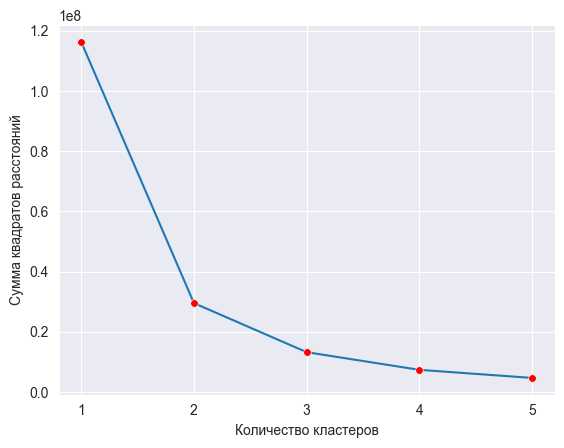

In [698]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline

K = range(1, 6)
wss = []

test_data = data.copy()
test_data['type_name'] = LabelEncoder().fit_transform(test_data['type_name'])

for k in K:
    pipe = Pipeline([('col_transformer', col_transformer),
                     ('kmeans', KMeans(n_clusters=k))])
    pipe.fit(test_data)
    wss.append(pipe.named_steps['kmeans'].inertia_)

sns.lineplot(x=K, y=wss, zorder=1)
sns.scatterplot(x=K, y=wss, color='red', s=30, zorder=2)

plt.xticks(K)
plt.xlabel('Количество кластеров')
plt.ylabel('Сумма квадратов расстояний')

### Вместо TF-IDF возьмём BERT

In [699]:
import torch
import numpy as np
from tqdm import tqdm
from sklearn.decomposition import PCA
from transformers import AutoTokenizer, AutoModel
from sklearn.base import TransformerMixin, BaseEstimator


class BertTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, model_name="sberbank-ai/ruBert-base", batch_size=32):
        self.model_name = model_name
        self.tokenizer = AutoTokenizer.from_pretrained(self.model_name)
        self.model = AutoModel.from_pretrained(self.model_name)
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model.to(self.device)
        self.batch_size = batch_size

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        self.model.eval()
        embeddings = []

        for i in tqdm(range(0, len(X), self.batch_size)):
            batch = X[i:i + self.batch_size].to_numpy()
            inputs = self.tokenizer(list(batch), return_tensors="pt", truncation=True, padding=True, max_length=128)
            inputs = {key: value.to(self.device) for key, value in inputs.items()}

            with torch.no_grad():
                outputs = self.model(**inputs)
                cls_embeddings = outputs.last_hidden_state[:, 0, :]

            embeddings.extend(cls_embeddings.cpu().numpy())

        embeddings_array = np.array(embeddings)
        pca = PCA(n_components=10)
        reduced_embeddings = pca.fit_transform(embeddings_array)
        return reduced_embeddings

    def get_feature_names_out(self, input_features=None):
        return ['v1', 'v2', 'v3', 'v4', 'v5',
                'v6', 'v7', 'v8', 'v9', 'v10']


In [700]:
bert_t = [
    ('name', BertTransformer(), 'name'),
    ('desc', BertTransformer(), 'description'),
    ('ohe', OneHotEncoder(drop=['франчайзинг']), ['theme']),
    ('time', DateTimeTransformer(), 'time_start'),
    ('scl', MinMaxScaler(), ['price'])
]

bert_col_transformer = ColumnTransformer(transformers=bert_t,
                                         remainder='passthrough',
                                         force_int_remainder_cols=False)

In [701]:
bert_data = data.copy()
bert_data['type_name'] = LabelEncoder().fit_transform(bert_data['type_name'])
bert_data.head()

,name,description,time_start,ticket_type_id,price,type_name,theme
0,мастер класс от партнера hochland трендовые рецепты пиццы,,2021-10-07 11:30:00+00:00,169,0.0,10,ресторан
1,виды пасты и равиоли техника лепки,уточняется,2021-10-05 11:30:00+00:00,155,0.0,10,ресторан
2,современное проектирование кухонных пространств в отеле,уточняется,2022-10-18 12:45:00+00:00,473,1500.0,16,ресторан
3,подбор оборудования для кондитерского и пекарского цеха в зависимости от размера помещения и потребностей,,2021-10-05 07:30:00+00:00,122,2000.0,16,ресторан
4,волжские сезоны особенности работы с локальными продуктами,,2021-10-07 12:30:00+00:00,13,0.0,10,ресторан


In [702]:
bert_data = bert_col_transformer.fit_transform(bert_data)
bert_cols = pd.Series(bert_col_transformer.get_feature_names_out()).apply(lambda x: x.replace('__', '_'))

bert_cols[26] = 'ticket_type_id'
bert_cols[27] = 'type'

bert_data = pd.DataFrame(bert_data, columns=bert_cols)
bert_data.to_csv('Data/events_bert.csv', index=False)
bert_data.head()

100%|██████████| 33/33 [01:17<00:00,  2.34s/it]


,name_v1,name_v2,name_v3,name_v4,name_v5,name_v6,name_v7,name_v8,name_v9,name_v10,desc_v1,desc_v2,desc_v3,desc_v4,desc_v5,desc_v6,desc_v7,desc_v8,desc_v9,desc_v10,ohe_theme_кофе,ohe_theme_отель,ohe_theme_ресторан,time_year,time_day,scl_price,ticket_type_id,type
0,-0.641853,-1.540561,-2.363020,-2.964641,3.059066,0.201723,0.569321,-0.382640,-1.582221,1.435719,-12.347379,-0.708549,-0.311671,0.316974,0.079605,0.048939,0.058322,0.033250,0.046076,0.008154,0.0,0.0,1.0,2021.0,2.0,0.000000,169.0,10.0
1,-0.997929,2.751572,0.820638,0.160515,4.049607,-0.862487,0.901545,-2.097210,1.898372,-1.085249,-2.746732,5.802743,0.179070,-7.752004,-3.373098,-3.210357,-1.200858,-1.872072,0.459818,0.548648,0.0,0.0,1.0,2021.0,0.0,0.000000,155.0,10.0
2,-1.609705,-0.470878,-1.753393,0.640660,0.389188,1.504862,2.074665,0.602573,0.320090,1.081897,-2.746732,5.802736,0.179075,-7.752015,-3.373120,-3.210348,-1.200868,-1.872035,0.459816,0.548643,0.0,0.0,1.0,2022.0,1.0,0.142857,473.0,16.0
3,5.436440,-2.625853,-1.385043,0.966439,-0.791192,0.767938,0.870060,-3.984420,2.874549,0.108018,-12.347376,-0.708587,-0.311641,0.316963,0.079583,0.048943,0.058376,0.033224,0.046093,0.008144,0.0,0.0,1.0,2021.0,0.0,0.190476,122.0,16.0
4,-1.937369,-0.658274,-1.558175,0.584765,1.964978,0.445323,-0.471028,-1.082842,0.789803,-0.492922,-12.347376,-0.708587,-0.311641,0.316963,0.079583,0.048944,0.058374,0.033219,0.046095,0.008141,0.0,0.0,1.0,2021.0,2.0,0.000000,13.0,10.0
